#     Make a DownGlacier run and have a look at the results

In [1]:
%pylab inline
import netCDF4
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('max_columns', 10)
pd.set_option('expand_frame_repr', True)
import seaborn as sns
pal = sns.color_palette('deep')
sns.set_context("talk", font_scale=1.2)
import os, shutil
import downglacier as dg
import downglacier.main as dgmain

Populating the interactive namespace from numpy and matplotlib


## 1. Input data

Make a working directory and copy the examples files in it

In [2]:
wd = os.path.join(os.path.expanduser("~"), 'DownGlacier_Example')
if not os.path.exists(wd):
    os.makedirs(wd)
os.chdir(wd)

In [3]:
fnames =  ['standard_run_predictands_shallap.nc',
           'standard_run_predictors_era.nc',
           'standard_run.cfg']
for fn in fnames:
    shutil.copyfile(os.path.join(dg.file_dir, 'tcd_paper', fn), os.path.join(wd, fn))

Have a look at the predictand file:

In [4]:
from subprocess import check_output
print(check_output(['ncdump', '-h', 'standard_run_predictands_shallap.nc']).decode("utf-8"))

netcdf standard_run_predictands_shallap {
dimensions:
	z = 23 ;
	time = 48 ;
variables:
	int z(z) ;
		z:units = "m" ;
		z:long_name = "Lower boundary of altitude step (m a.s.l.)" ;
	int time(time) ;
		time:units = "hours since 2000-1-1 00:00:00" ;
		time:long_name = "time" ;
	double A_h(z) ;
		A_h:units = "m^2" ;
		A_h:long_name = "Area (horizontal: A=dx^2;dx=dy)" ;
	double A_sc(z) ;
		A_sc:units = "m^2" ;
		A_sc:long_name = "Area (corrected for slope: A=dc*dx; dc=sqrt(dx^2+dz^2);dz=dx*tan(slope);Assumption: dx=dy)" ;
	double Slope(z) ;
		Slope:units = "degree" ;
		Slope:long_name = "Slope" ;
	double LWin(time, z) ;
		LWin:long_name = "incomming longwave radiation" ;
		LWin:units = "W m^-2" ;
	double LWout(time, z) ;
		LWout:long_name = "outgoing longwave radiation" ;
		LWout:units = "W m^-2" ;
	double SWnet(time, z) ;
		SWnet:long_name = "net shortwave radiation" ;
		SWnet:units = "W m^-2" ;
	double TS(time, z) ;
		TS:long_name = "surface temperature" ;
		TS:units = "K" ;
	double sfac

The file has two dimensions (time and z), with z being the altitude slices on the glacier. We can have a look at the mass-balance profile of Shallap glacier:

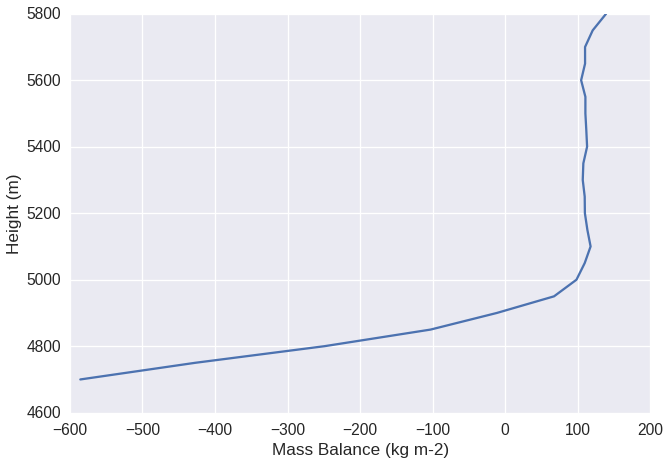

In [5]:
nc = netCDF4.Dataset('standard_run_predictands_shallap.nc')
p = plt.plot(np.mean(nc.variables['totalmbnotacc'], axis=0), nc.variables['z'])
p = plt.xlabel('Mass Balance (kg m-2)')
p = plt.ylabel('Height (m)')

Now read the predictor file:

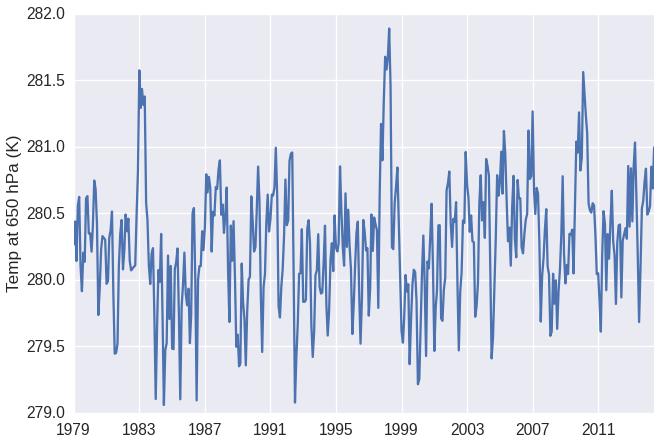

In [6]:
nc = netCDF4.Dataset('standard_run_predictors_era.nc')
time = nc.variables['time']
time = netCDF4.num2date(time[:], units=time.units)
p = plt.plot_date(time, nc.variables['t_650hPa'][:], '-')
p = plt.ylabel('Temp at 650 hPa (K)')

## 2. Run DownGlacier

You can have a look at the 'tcd_run_std.cfg' configuration file. It is setted on a LASSO run for the z_level 4750, with a model selection cross-validation parameter of 4 (k-fold) and an outer cross-valitation parameter of 2 (leave-5-out).  

There are two possible ways to run DownGlacier. On the command line ("downglacier tcd_run_std.cfg") or directly from Python:

In [7]:
dgmain.workflow('standard_run.cfg')

/home/mowglie/.pyvirtualenvs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Convergence warnings can happen when using Lasso CV but they are usually not a problem. This occurs when computing the lasso path and for certain values of the lasso penalization coefficient.

The output of DownGlacier is written in a single directory specified in the configuration file, in our case: 'working_directory/output'.

## 3. Check input

The "checkinput" directory contains 4 files:

#### predictands_stats.csv

A table containing information about the predictands. Simple things like their unit, mean, standard deviation but also two normality tests: [Anderson-Darling and Shapiro-Wilk](http://www.itl.nist.gov/div898/handbook/prc/section2/prc213.htm) tests. In addition, the auto-correlation $r^{2}$ for lags 1 to 12 months are given.

In [8]:
sdf = pd.read_csv('output/checkinput/predictands_stats.csv', index_col=0)
sdf.head()

unit    mean  stddev  shapirotest_w  \
airtemp_4750_ds              degC    1.58    0.39           0.96   
lwin_4750_ds               W m^-2  276.84   16.37           0.95   
lwnet_4750_ds              W m^-2  -32.70   14.34           0.94   
lwout_4750_ds              W m^-2 -309.55    2.42           0.98   
mbspec_0_ds      mm w.e. month^-1   38.31  116.91           0.97   

                 shapirotest_pval     ...     autocor_8 autocor_9  autocor_10  \
airtemp_4750_ds              0.10     ...          0.00      0.01        0.02   
lwin_4750_ds                 0.04     ...          0.11      0.01        0.05   
lwnet_4750_ds                0.01     ...          0.12      0.01        0.05   
lwout_4750_ds                0.68     ...          0.02      0.00        0.03   
mbspec_0_ds                  0.32     ...          0.02      0.00        0.02   

                 autocor_11  autocor_12  
airtemp_4750_ds        0.04        0.03  
lwin_4750_ds           0.24        0.35  
lwnet_4750_ds          0.24        0.37  
lwout_4750_ds          0.11        0.13  
mbspec_0_ds            0.13        0.14  

[5 rows x 19 columns]

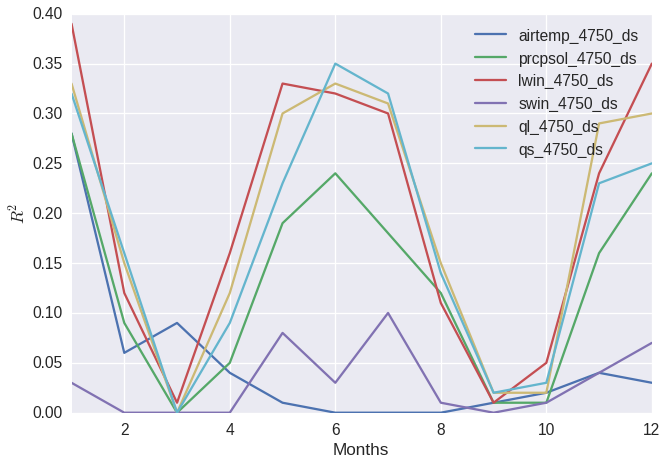

In [9]:
sdfa = sdf[['autocor_{}'.format(i) for i in np.arange(1, 13)]].T
sdfa.index = np.arange(1, 13)
ax = sdfa[['airtemp_4750_ds','prcpsol_4750_ds','lwin_4750_ds','swin_4750_ds','ql_4750_ds','qs_4750_ds']].plot();
ax.set_xlabel("Months");
ax.set_ylabel("$R^2$");

In [10]:
sdfa.loc[3]

airtemp_4750_ds        0.09
lwin_4750_ds           0.01
lwnet_4750_ds          0.01
lwout_4750_ds          0.00
mbspec_0_ds            0.02
mbtot_4750_ds          0.08
meltmass_4750_ds       0.12
prcpsol_4750_ds        0.00
prcptot_4750_ds        0.00
qc_4750_ds             0.01
ql_4750_ds             0.00
qm_4750_ds             0.13
qps_4750_ds            0.03
qs_4750_ds             0.00
submass_4750_ds        0.00
subsurfmass_4750_ds    0.08
swin_4750_ds           0.00
swnet_4750_ds          0.03
swout_4750_ds          0.04
vp_4750_ds             0.01
ws_4750_ds             0.00
Name: 3, dtype: float64

All predictands have very low auto-correlation values for lag 2 already. There is an obvious half-yearly and yearly cycle for some of them.

#### precheck-results.csv and check-smb.pdf

These are the results of the "perfect downscaling" approach, in which it is tested that Downglacier is able to calculate the diagnostic variables given perfectly downscaled predictands. At the 4750m altitude slice, the results are almost perfect (RMSE of 3.26 $kg m^{-2} month^{-1}$, which is roughly 1% error). See if DownGlacier works well for other altitudes too too:

In [11]:
# Make a new config file just to check the input
from configobj import ConfigObj
cp = ConfigObj('standard_run.cfg', file_error=True)
cp['I/O']['working_dir'] = './checkinput_allz'
del cp['I/O']['keep_zlevels']
cp['Screen']['run'] = False
cp['Regstats']['run'] = False
cp['Diagnostic']['run'] = False
cp.filename = 'checkinput_allz.cfg'
cp.write()

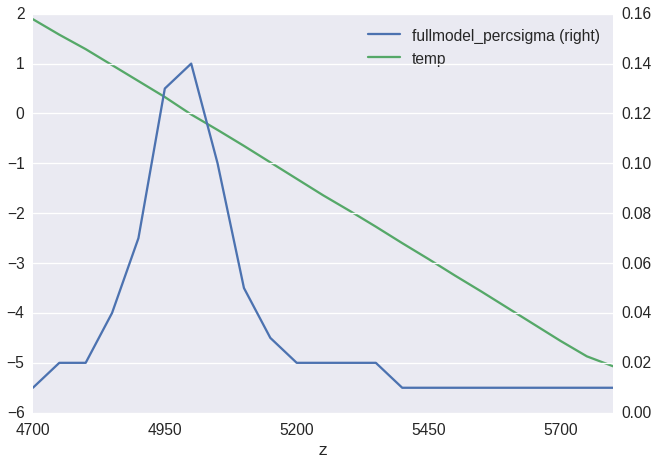

In [12]:
dgmain.workflow('checkinput_allz.cfg')
sdf = pd.read_csv('checkinput_allz/checkinput/precheck-results.csv', index_col=0)
sdf = sdf[sdf.varname == 'mbtotfromsum']
sdf['z'] = [s.split('_')[1] for s in sdf.index]
sdscores = sdf.set_index('z')
sdf = pd.read_csv('checkinput_allz/checkinput/predictands_stats.csv', index_col=0)
sdf = sdf.loc[['airtemp' in s for s in sdf.index]]
sdf['z'] = [s.split('_')[1] for s in sdf.index]
sdscores['temp'] = sdf.set_index('z')['mean']
sdscores[['fullmodel_percsigma','temp']].plot(secondary_y='fullmodel_percsigma');

The maximum error (in % of standard deviation) is 14%, the highest errors occurring where average air temperature is close to 0°, as expected. 

#### collinearity_warnings.txt

This file contains a list of the predictor pairs collinear at 95 and 98%. Highly collinear predictors add noise to the system without much skill gain, they should be removed a-priori.

## 4. Downscaling results

The "screening" folder contains several files:
    - fullmodel_ts.csv: the time series predicted by the full model during the caibration period
    - cv_tc.csv: the time series predicted by the (bad) cross-validation model
    - outercv_ts.csv: the time series predicted by the (true) outer cross-validation model
    - predict_ts.csv: the time series predicted by the full model for the full predictor period
    - regression-plots.pdf: depending on the model used, some plots (with Lasso: lasso-path)
    - regression-summary.txt: some regression scores (empt for the Lasso)
    - results.csv: the screening scores and statistics for all downscaled variables
    - results.p: the whole state of DownGlacier at the time of writing, in a pickle file

Let's have a look at the results first:

In [13]:
df = pd.read_csv('output/screening/results.csv', index_col=0)
df.head()

varname  nselpreds  \
key                                   
airtemp_4750_ds  airtemp         14   
lwin_4750_ds        lwin          8   
lwnet_4750_ds      lwnet          9   
lwout_4750_ds      lwout         11   
mbspec_0_ds       mbspec          7   

                                                          selpreds    mean  \
key                                                                          
airtemp_4750_ds  +20 t_650hPa, -13 rh_450hPa, +12 rh_650hPa, +1...    1.58   
lwin_4750_ds     +60 rh_550hPa, +12 v_450hPa, +7 rh_450hPa, +7 ...  276.84   
lwnet_4750_ds    +59 rh_550hPa, +17 rh_450hPa, +12 v_450hPa, +4...  -32.70   
lwout_4750_ds    -33 rh_550hPa, -18 t_450hPa, -14 t_650hPa, +10... -309.55   
mbspec_0_ds      +53 rh_450hPa, -22 t_650hPa, +11 v_350hPa, +6 ...   38.31   

                 stddev         ...          cv_skillscore  outercv_rmse  \
key                             ...                                        
airtemp_4750_ds    0.39         ...                   0.87          0.18   
lwin_4750_ds      16.19         ...                   0.75          4.71   
lwnet_4750_ds     14.19         ...                   0.75          3.78   
lwout_4750_ds      2.39         ...                   0.67          1.23   
mbspec_0_ds      115.68         ...                   0.56         68.69   

                 outercv_r2  outercv_percsigma  outercv_skillscore  
key                                                                 
airtemp_4750_ds        0.78               0.47                0.82  
lwin_4750_ds           0.92               0.29                0.73  
lwnet_4750_ds          0.93               0.27                0.76  
lwout_4750_ds          0.74               0.51                0.63  
mbspec_0_ds            0.65               0.59                0.50  

[5 rows x 17 columns]

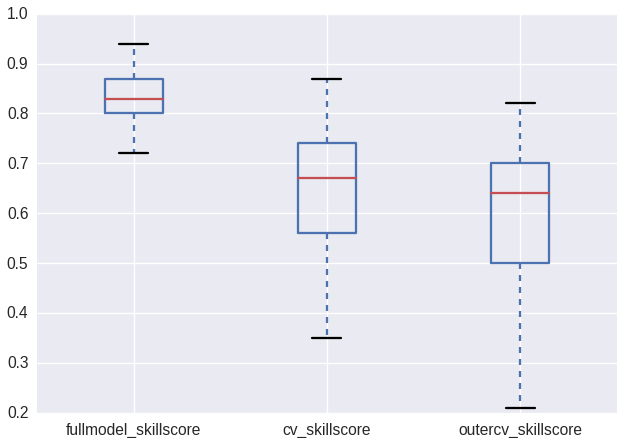

In [15]:
df[['fullmodel_skillscore','cv_skillscore','outercv_skillscore']].plot(kind='box');

We see that the skill scores are very high for the full model for all variables. However, this score is biased because the model has all informations at hand to make a "good" model. The outer cross-validation score is much closer to the real capacity of the model to predict an unknown outcome. 